<a href="https://colab.research.google.com/github/borislav-milkov/BuzzSolutions-Challenge/blob/master/BuzzSolutions_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook takes about 2 minutes to run on a GPU accelerated Google Colab instance**

In [60]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

BATCH_SIZE = 100
EPOCHS = 36
LEARN_RATE = 0.003

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Some digging reveals that the mnist data set is already split in a test and train datasets, let us inspect the split.

In [50]:
x_train = mnist.train.images
y_train = mnist.train.labels

x_test = mnist.test.images
y_test = mnist.test.labels

# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=x_train.shape))
print("Training set (labels) shape: {shape}".format(shape=y_train.shape))

print()

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=x_test.shape))
print("Test set (labels) shape: {shape}".format(shape=y_test.shape))

Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)

Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


We have 50,000 entries for training and 10,000 entries for testing and mode levaluation. We can also see that the images seem to be 1D tensors with 784 values. From the publicly available information about the dataset we see that the images are 28x28 originally, our data is flattened into just one dimension and hence 784 (=28\*28) values. Let us see how these flattened images look.

In [0]:
#function to display multiple flattened images
def display_mult_flat(start, stop):
    images = x_train[start].reshape([1,784])
    for i in range(start,stop):
        images = np.concatenate((images, x_train[i].reshape([1, 784])))
    plt.figure(figsize = (12,12))
    plt.imshow(images)
    plt.show()

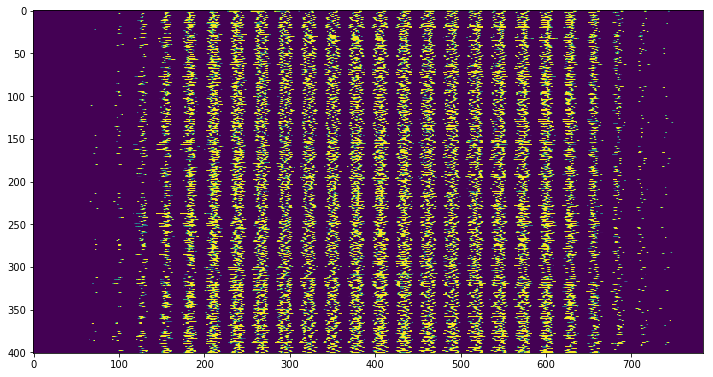

In [52]:
display_mult_flat(0, 400)

In [0]:
def display_digit(num):
    print(y_train[num])
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


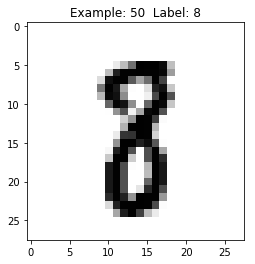

In [54]:
display_digit(50)

Flattened images are great for dense Multilayer Perceptron Models, but since we're aiming for very high accuracy and have the domain knowledge to know that image related tasks lend themselves to CNN architectures, we will resize the images back to 28x28 so that we can stack convolutinal layers ontop of them.

In [55]:
#reshaping images
print("Inputs before reshaping: {}".format(x_train.shape))
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])
print("Inputs before reshaping: {}".format(x_train.shape))

Inputs before reshaping: (55000, 784)
Inputs before reshaping: (55000, 28, 28, 1)


Let us define our Tensorflow Graph. This is where we specify what data we will use, it's dimensions and what operations will be performed on it. Later we will just have to start a session with this graph and run it with the appropriate data inputs. Our graph will have the following architecture:

**Inputs:**

X : input images  
Y_ : input labels  
lr : learning rate  
prob_keep : what percent of elements we keep in the dropout layer before the logits fully connected layer

**Model Architecture:**

conv2d (6x6 kernel) with leaky_relu activation  
conv2d (5x5 kernel) with leaky_relu activation  
conv2d (4x4 kernel) with leaky_relu activation  
flatten result of last convolution  
dense fully connected layer  with leaky_relu activation  
dropout (used to regularize)  
dense fully connected layer  
softmax activation  


![](https://cdn-images-1.medium.com/max/900/1*4GLv7_4BbKXnpc6BRb0Aew.png)

Our architecture is similar to this except we don't include max-pooling layers and our final layer classifies digits instead of boat, house, etc. We also use leaky_relu instead of plain relu activations to prevent neurons in our neural netweork from dying. This can happend due to the 0 nature of the relu for negative inputs.

In [0]:
s = tf.reset_default_graph()
# Define Tensorflow graph
X = tf.placeholder(tf.float32, [None, 28, 28, 1]) # placeholder for image data
Y_ = tf.placeholder(tf.float32, [None, 10]) # placeholder for labels
lr = tf.placeholder(tf.float32) #placeholder for learning rate
prob_keep = tf.placeholder(tf.float32) #percent of neurons to be dropped in the final FC layer, used for regularization

K = 6  # first convolutional layer output depth
L = 12  # second convolutional layer output depth
M = 24  # third convolutional layer
N = 200  # fully connected layer (softmax)

W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 kernel, 1 input channel, K output channels
B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))  #5x5 kernel, K input channels, L output channels
B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))  #4x4 kernel, L input channels, M output channels
B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))

W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))

 #The model
stride = 1  # We will be sliding the kernels one pixel at a time, output after 28x28
Y1 = tf.nn.leaky_relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
stride = 2  # output is 14x14
Y2 = tf.nn.leaky_relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
stride = 2  # output is 7x7
Y3 = tf.nn.leaky_relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

Y4 = tf.nn.leaky_relu(tf.matmul(YY, W4) + B4)
YY4 = tf.nn.dropout(Y4, prob_keep)
Ylogits = tf.matmul(YY4, W5) + B5
Y = tf.nn.softmax(Ylogits)

Let us now look what calculations we will need to perform with the graph defined above. Since this is a classification task we will need to see how well our model predicts labels as compared to the ground truth labels. By our definition of the output Y = tf.nn.softmax(Ylogits) we predict a vector with 10 values where each value is the probability that the underlying image belongs to a class. 

For example:
    A good model, when fed an image of the number 8, might produce a prediction vector of [0, 0.04, 0, 0, 0, 0, 0, 0, 0.91, 0.05]. Notice that the 8th position in this vector is very high, meaining that the probability that is indeed an 8 is 91%. All probabilities sum to 1 due to how the softmax function creates the probability distribution. We just have to take the highest probability in this vector and make that index our prediction label.
    
To compare our prediction vector with the true vector and calculate how wrong we are(ie. loss function) we will use Cross Entropy Loss, which works great for these kind of discrete prediction tasks. It looks like this:
$$ H(y, \hat{y}) = \sum_i y_i \log \frac{1}{\hat{y}_i} = -\sum_i y_i \log \hat{y}_i $$  

**Learning Rate:**  
An exponentially decaying learning rate is used so that we can hone down on a global minimum and avoid getting stuck in local minima. The learning rate starts at 0.003(fed at runtime) and then exponentially decays with each batch.  
**Accuracy:**  
For the accuracy we will use   
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/e2e427ec6dcf2d7882c3bbdc659a8204cba59dcc)  
A weakness of this accuracy score is class imbalances, but since our data is split evenly across classes we can be fairly certain that it will provide a reliable metric of model performance.


In [57]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)

# accuracy of the trained model, between 0 (worst) and 1 (best)
predictions = tf.argmax(Y, 1)
true_labels = tf.argmax(Y_, 1)
confusion = tf.confusion_matrix(true_labels, predictions, num_classes=10)
correct_prediction = tf.equal(predictions, true_labels) # was our prediction correct
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # average all correct prediction scores across all predictions for an overall accuracy

batch = tf.Variable(0)

# training step, the learning rate is a placeholder
learning_rate = tf.train.exponential_decay(
  lr,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  x_train.shape[0],          # Decay step.
  0.92,                # Decay rate.
  staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step=batch)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


Time to put our constructed graph to use by actually training our defined model

In [58]:
# initialize tf variables and create our session for the computation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# storing metrics and loss for plotting later
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, x_train.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = sess.run([train_step, cross_entropy], {X: x_train[batch_start:batch_start+BATCH_SIZE], 
                                                Y_: y_train[batch_start:batch_start+BATCH_SIZE],
                                                lr: LEARN_RATE,
                                                prob_keep: 0.75})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        # we'll plot these later
        batch_losses.append(batch_loss)
    
    train_loss.append(np.mean(batch_losses))
    test_loss.append(sess.run(cross_entropy, {X: x_test, Y_: y_test, prob_keep: 1.0}))  # this part is usually small
    train_acc.append(sess.run(accuracy, {X: x_train, Y_: y_train, prob_keep: 1.0}))  # this is slow and usually skipped
    test_acc.append(sess.run(accuracy, {X: x_test, Y_: y_test, prob_keep: 1.0}))
    
    #some logging
    print()
    print("Epoch : ", epoch+1)
    print("Training Loss: {}".format(train_loss[-1]))
    print("Training Accuracy: {}".format(train_acc[-1]))
    print("Test Loss: {}".format(test_loss[-1]))
    print("Test Accuracy: {}".format(test_acc[-1]))


Epoch :  1
Training Loss: 0.22945737838745117
Training Accuracy: 0.9731636643409729
Test Loss: 0.0854995995759964
Test Accuracy: 0.9732999801635742

Epoch :  2
Training Loss: 0.07707853615283966
Training Accuracy: 0.983054518699646
Test Loss: 0.06036744266748428
Test Accuracy: 0.9781000018119812

Epoch :  3
Training Loss: 0.05598435178399086
Training Accuracy: 0.987890899181366
Test Loss: 0.04736338555812836
Test Accuracy: 0.9846000075340271

Epoch :  4
Training Loss: 0.04366259649395943
Training Accuracy: 0.9868727326393127
Test Loss: 0.05481838434934616
Test Accuracy: 0.9821000099182129

Epoch :  5
Training Loss: 0.03742525354027748
Training Accuracy: 0.9898363351821899
Test Loss: 0.04597937688231468
Test Accuracy: 0.9866999983787537

Epoch :  6
Training Loss: 0.03152477741241455
Training Accuracy: 0.9900727272033691
Test Loss: 0.05146368592977524
Test Accuracy: 0.9858999848365784

Epoch :  7
Training Loss: 0.027387285605072975
Training Accuracy: 0.9942181706428528
Test Loss: 0.0377

We can see that we get 99.2% accuracy with our model in about 1-2 minutes of training on Google Colab. Let us see how the loss and accuracies of train and test compare graphically.

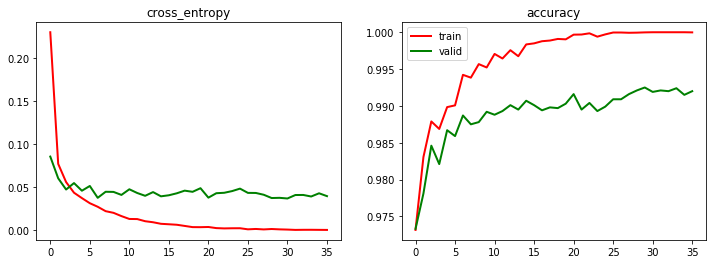

In [63]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1.set_title("cross_entropy")
ax2.set_title("accuracy")
train_loss_curve = ax1.plot(np.arange(EPOCHS), train_loss, 'r', label='train', lw=2)
valid_loss_curve = ax1.plot(np.arange(EPOCHS), test_loss, 'g', label='valid', lw=2)
train_metric_curve = ax2.plot(np.arange(EPOCHS), train_acc, 'r', label='train', lw=2)
valid_metric_curve = ax2.plot(np.arange(EPOCHS), test_acc, 'g', label='valid', lw=2)

plt.legend(loc="best")
plt.show()

We seem to have the validation/test loss under control. This means our dropout layer did it's job and allowed the model to generalize well. Let us see what we have misclassified in more detail with a confusion matrix.

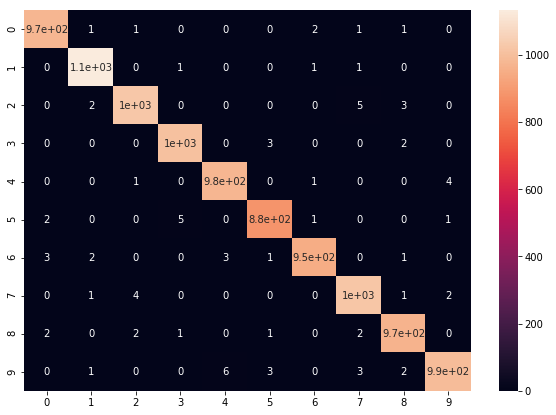

In [64]:
plt.figure(figsize = (10,7))
confusion_mat = sess.run(confusion, {X: x_test, Y_: y_test, prob_keep: 1.0})
sns.heatmap(confusion_mat, annot=True)

We can see that 7 is confused with 2, 5 times and 3 is confsed for 5, 5 times. These digits could appear similar when written our, especially if done in a hurry so it is no surprise these are misclassified. Nothing to worry about, however, as such small number of misclassifications is minute compared to the overall number of test samples. This concludes this exploration into digit classification.   

**To recap:**

1.   We build analysed the data and reshaped it to our needs  
2.   We created our model's architecture using Tensorflow in the form of a graph
3.   We specified the accuracy to be logged and cross entropy loss to be minimized
4.   Trained the model a specified number of epochs (36) with a batch size (100) 
5.   Logged and observed the model's performance throughout training and post-training  

For any questions feel free to email me at: borislavantoan.milkov@sjsu.edu


